# Avaliação do Baseline

Ao longo desse notebook será avaliado o modelo já existente para o dataset, avaliando tanto métricas de modelagem quanto métricas de negócio. O objetivo dessa analise é entender a performance e estabilidade do modelo atual.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score, auc
import matplotlib.pyplot as plt
from scipy.stats import kstest
from datetime import datetime

## Dados

In [2]:
df = pd.read_csv('../data/raw/fraud_dataset_v2.csv', index_col=0)

In [57]:
print(df.shape)
print(df.drop_duplicates().shape)
df.head()

(250000, 26)
(250000, 26)


,a,b,c,d,e,f,g,h,i,j,...,q,r,s,fecha,monto,score,fraude,valor_fraude,anomesdia,faixa_score
0,4,0.7685,94436.24,20.0,0.444828,1.0,BR,5,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,...,0.40,94436,0,2020-03-27 11:51:16,5.64,66.0,0,0.00,20200327,"(65.0, 70.0]"
1,4,0.7550,9258.50,1.0,0.000000,33.0,BR,0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,...,0.02,9258,0,2020-04-15 19:58:08,124.71,72.0,0,0.00,20200415,"(70.0, 75.0]"
2,4,0.7455,242549.09,3.0,0.000000,19.0,AR,23,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,...,0.06,242549,0,2020-03-25 18:13:38,339.32,95.0,0,0.00,20200325,"(90.0, 95.0]"
3,4,0.7631,18923.90,50.0,0.482385,18.0,BR,23,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,...,0.98,18923,100,2020-04-16 16:03:10,3.54,2.0,0,0.00,20200416,"(-0.001, 5.0]"
4,2,0.7315,5728.68,15.0,0.000000,1.0,BR,2,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,...,0.28,5728,0,2020-04-02 10:24:45,3.53,76.0,1,3.53,20200402,"(75.0, 80.0]"


## Métricas dos Dados

In [4]:
print(f'Bad rate: {df.fraude.mean()}')
print(f'Qtd. Maus: {df.fraude.sum()}\nQtd. Bons: {df.shape[0]-df.fraude.sum()}')

Bad rate: 0.030008
Qtd. Maus: 7502
Qtd. Bons: 242498


Antes de começar a análise do score é importante entender algumas métricas da tabela para escolher as melhores métricas para avalia-lo.  
Já nos foi adiantado que é dataset é de fraude em um e-commerce, fazendo uma segunda validação temos um problema desbalanceado, 3%/300 BPs, com isso vamos utilizar métricas para esse tipo de problema:  
- ROC AUC  
- PR AUC  
- Precision  Qtd. e Financeiro  
- Recall  Qtd. e Financeiro

Trabalhando com um caso de fraude, onde devemos decidir aprovar ou não uma transação, temos um impacto direto na experiencia do cliente, então nesses casos normalmente é avaliado o desempenho do score em um ponto de impacto específico, para isso vamos utilizar as métricas listadas acima, limitadas a 1% de impacto em qtd de transações.  

Além das métricas de modelagem também vamos avaliar uma métrica de ROI indicada pelo time de negócio em diferentes pontos de impacto [0.1%, 1%], dessa forma vamso conseguir fazer uma espécie de ROI AUC.  

## Métricas do Baseline

In [5]:
# Nenhum nulo presente na coluna de score, nem na de fraude.
# Vamos seguir com a avaliação.
df[['score', 'fraude']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 250000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   score   250000 non-null  float64
 1   fraude  250000 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 5.7 MB


### Métricas de Modelagem

In [6]:
# A fraude parece estar nume dimens]ao menor que o score, não parece estar evoluindo junto com as casas decimais, talvez 
# de pra reduzir essas casas, não estão agregando no score
df['valor_fraude'] = df['monto'] * df['fraude']
df_thresholds = (
    df
    .groupby('score')
    .agg({'fraude' : ['sum', 'count'],
          'valor_fraude' : 'sum',
          'monto' : 'sum'})
    .sort_values(by='score', ascending=False)
    .cumsum()
    .reset_index()
)
df_thresholds.columns = ['score', 'qtd_fraude', 'qtd_total', 'valor_fraude', 'valor_total']
df_thresholds['fpr_#'] = (df_thresholds['qtd_total'] - df_thresholds['qtd_fraude'])/(df_thresholds['qtd_total'].max() - df_thresholds['qtd_fraude'].max())
df_thresholds['fpr_$'] = (df_thresholds['valor_total'] - df_thresholds['valor_fraude'])/(df_thresholds['valor_total'].max() - df_thresholds['valor_fraude'].max())
df_thresholds['precision_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_total']
df_thresholds['precision_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_total']
df_thresholds['recall_#'] = df_thresholds['qtd_fraude']/df_thresholds['qtd_fraude'].max()
df_thresholds['recall_$'] = df_thresholds['valor_fraude']/df_thresholds['valor_fraude'].max()
df_thresholds.iloc[188:195,:]

,score,qtd_fraude,qtd_total,valor_fraude,valor_total,fpr_#,fpr_$,precision_#,precision_$,recall_#,recall_$
188,98.03,743,3350,50684.80,197839.97,0.010751,0.014201,0.221791,0.256191,0.099040,0.092609
189,98.02,743,3355,50684.80,198072.45,0.010771,0.014223,0.221461,0.255890,0.099040,0.092609
190,98.01,743,3361,50684.80,198332.26,0.010796,0.014248,0.221065,0.255555,0.099040,0.092609
191,98.00,924,4074,65861.12,248762.36,0.012990,0.017650,0.226804,0.264755,0.123167,0.120338
192,97.99,924,4078,65861.12,248848.15,0.013006,0.017659,0.226582,0.264664,0.123167,0.120338
193,97.98,924,4083,65861.12,249242.60,0.013027,0.017697,0.226304,0.264245,0.123167,0.120338
194,97.97,924,4086,65861.12,249317.18,0.013039,0.017704,0.226138,0.264166,0.123167,0.120338


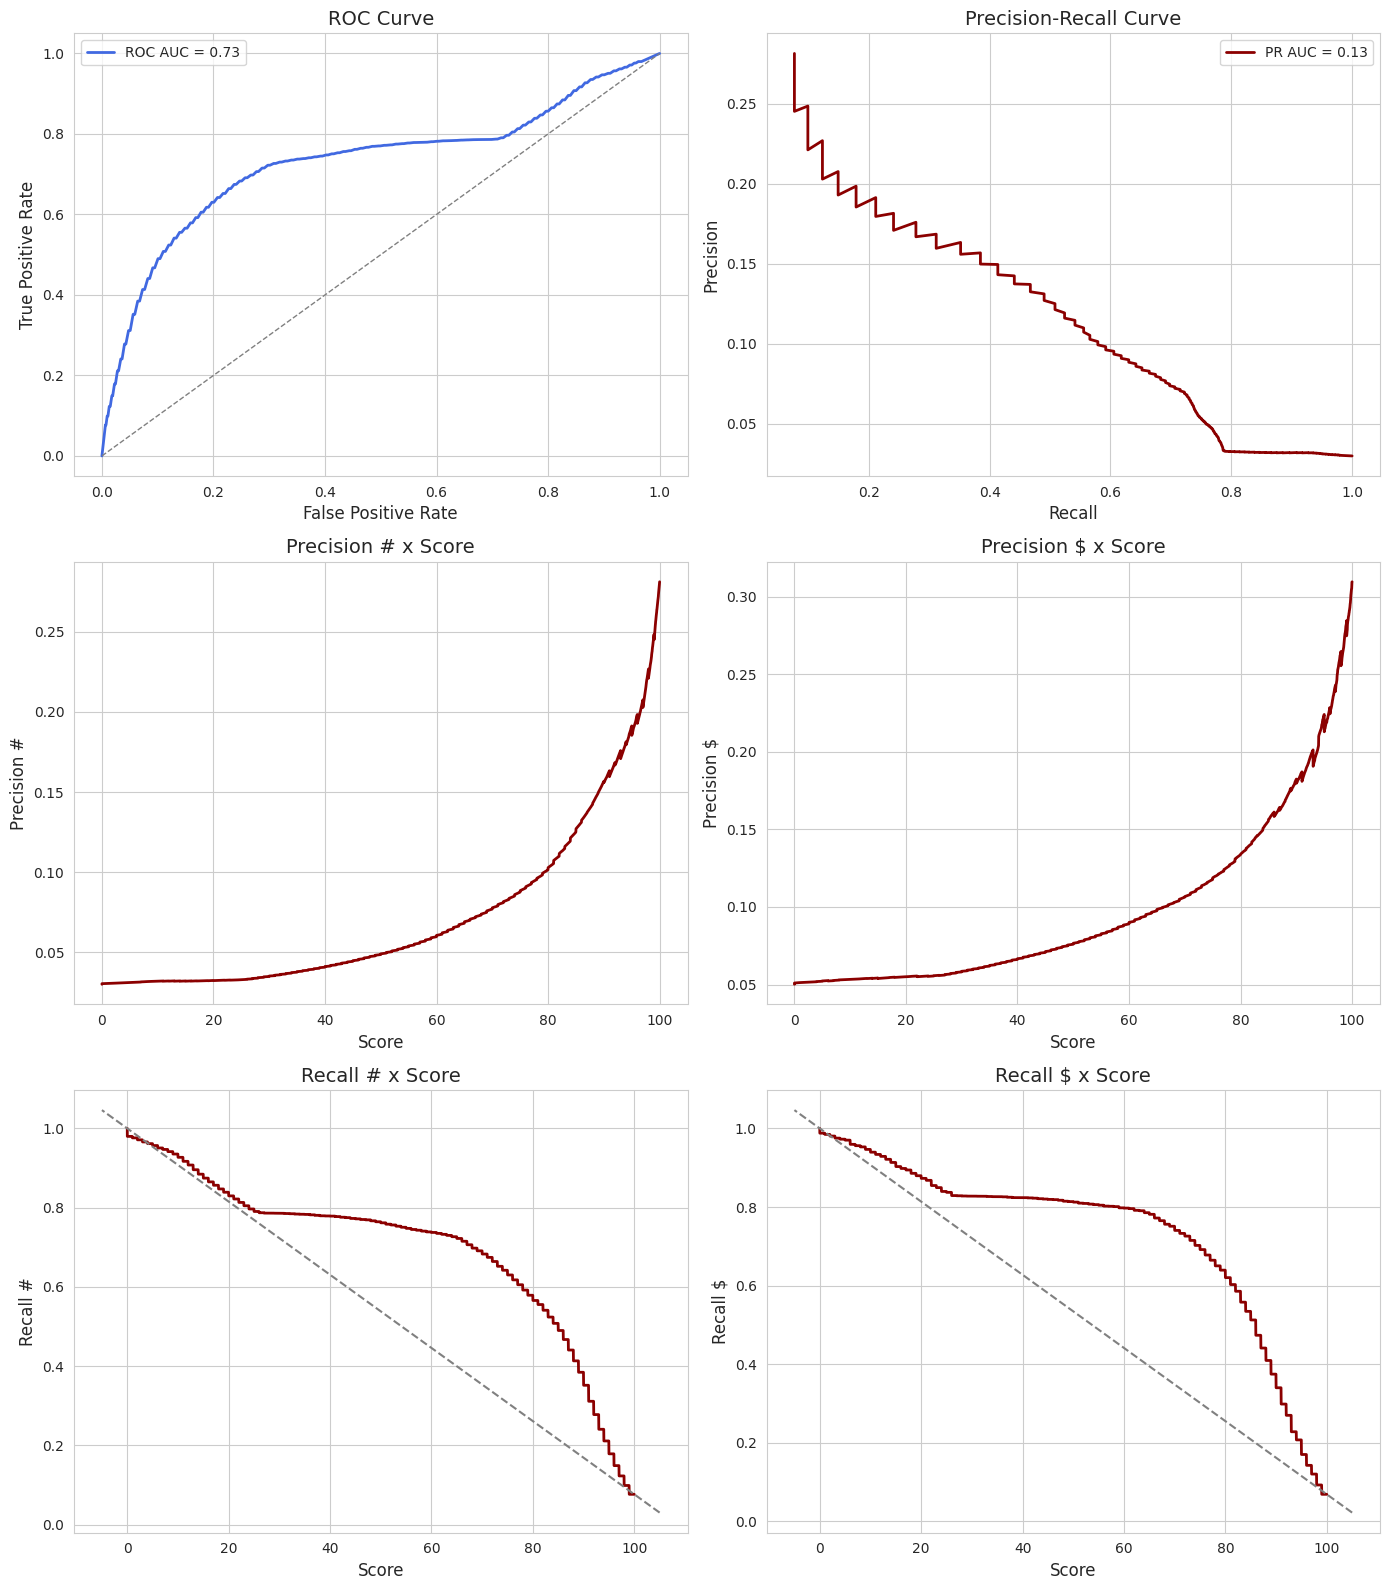

In [7]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 16))
colors = ["royalblue", "darkred"]

# ROC Curve
fpr, tpr, th_roc = roc_curve(df['fraude'], df['score'])
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, color=colors[0], linewidth=2, label=f'ROC AUC = {roc_auc:.2f}')
axes[0, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14)
axes[0, 0].legend()

# Precision-Recall Curve
pr_auc = average_precision_score(df['fraude'], df['score'])
axes[0, 1].plot(df_thresholds['recall_#'], df_thresholds['precision_#'], color=colors[1], linewidth=2, label=f'PR AUC = {pr_auc:.2f}')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14)
axes[0, 1].legend()

# Precision # x Score Curve
axes[1, 0].plot(df_thresholds['score'], df_thresholds['precision_#'], color=colors[1], linewidth=2)
axes[1, 0].set_xlabel('Score', fontsize=12)
axes[1, 0].set_ylabel('Precision #', fontsize=12)
axes[1, 0].set_title('Precision # x Score', fontsize=14)

# Precision $ x Score Curve
axes[1, 1].plot(df_thresholds['score'], df_thresholds['precision_$'], color=colors[1], linewidth=2)
axes[1, 1].set_xlabel('Score', fontsize=12)
axes[1, 1].set_ylabel('Precision $', fontsize=12)
axes[1, 1].set_title('Precision $ x Score', fontsize=14)

# Recall # x Score Curve
axes[2, 0].plot(df_thresholds['score'], df_thresholds['recall_#'], color=colors[1], linewidth=2)
axes[2, 0].set_xlabel('Score', fontsize=12)
axes[2, 0].set_ylabel('Recall #', fontsize=12)
axes[2, 0].set_title('Recall # x Score', fontsize=14)

# Recall $ x Score Curve
axes[2, 1].plot(df_thresholds['score'], df_thresholds['recall_$'], color=colors[1], linewidth=2)
axes[2, 1].set_xlabel('Score', fontsize=12)
axes[2, 1].set_ylabel('Recall $', fontsize=12)
axes[2, 1].set_title('Recall $ x Score', fontsize=14)

for ax in [axes[2, 0], axes[2, 1]]:
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    ax.plot([x_max, x_min], [y_min, y_max], color='gray', linestyle='--', linewidth=1.5)

plt.tight_layout()
plt.show()

É possível enxergar um comportamento estranho no score abaixo de 20, indicando quase que aleatoriedade

### Distribuição

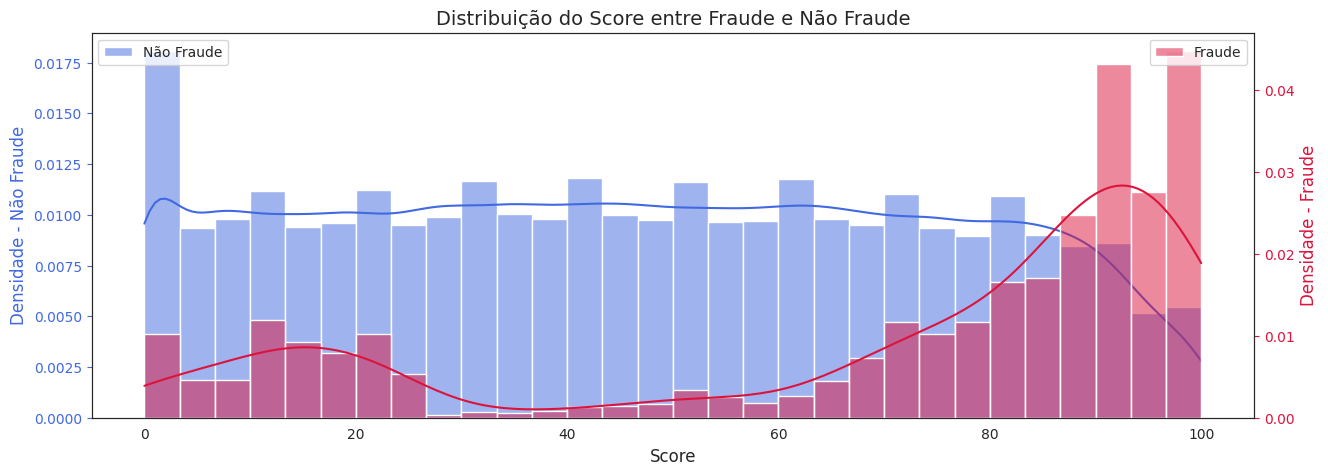

In [8]:
sns.set_style("white")

plt.figure(figsize=(15, 5))

ax1 = plt.gca()
ax2 = ax1.twinx()

sns.histplot(
    data=df[df['fraude'] == 0], x="score", kde=True, stat="density",
    bins=30, color="royalblue", alpha=0.5, label="Não Fraude", ax=ax1
)

sns.histplot(
    data=df[df['fraude'] == 1], x="score", kde=True, stat="density",
    bins=30, color="crimson", alpha=0.5, label="Fraude", ax=ax2
)

ax1.set_xlabel("Score", fontsize=12)
ax1.set_ylabel("Densidade - Não Fraude", color="royalblue", fontsize=12)
ax2.set_ylabel("Densidade - Fraude", color="crimson", fontsize=12)

ax1.tick_params(axis="y", colors="royalblue")
ax2.tick_params(axis="y", colors="crimson")

plt.title("Distribuição do Score entre Fraude e Não Fraude", fontsize=14)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

A distribuição do score nos ajuda a enxergar essa possível aleatoriedade no score abaixo de 20, vamos um acumulo de fraudes concentrado nessa faixa.

## Avaliação ao longo do tempo

In [9]:
df['anomesdia'] = df['fecha'].str[0:10].str.replace('-','', regex=True).astype(int)

In [10]:
df_auc_safrada = pd.DataFrame([
    [
        str(anomesdia),
        roc_auc_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        average_precision_score(df[df['anomesdia'] == anomesdia]['fraude'], df[df['anomesdia'] == anomesdia]['score']),
        df[df['anomesdia'] == anomesdia]['fraude'].mean(),
        df[df['anomesdia'] == anomesdia].shape[0],
        df[df['anomesdia'] == anomesdia]['fraude'].sum()
    ]
    for anomesdia in df['anomesdia'].unique()
], columns=['anomesdia', 'roc_auc', 'pr_auc', 'br', 'qtd_trans', 'qtd_fraude']).sort_values(by='anomesdia')



In [11]:
df_auc_safrada['media_movel_roc_auc'] = df_auc_safrada['roc_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_pr_auc'] = df_auc_safrada['pr_auc'].rolling(window=7).mean()
df_auc_safrada['media_movel_br'] = df_auc_safrada['br'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_trans'] = df_auc_safrada['qtd_trans'].rolling(window=7).mean()
df_auc_safrada['media_movel_qtd_fraude'] = df_auc_safrada['qtd_fraude'].rolling(window=7).mean()

/tmp/ipykernel_325918/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_325918/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_325918/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_325918/4173622012.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
/tmp/ipykernel_325918/4173622012.py:20: UserWarning: set

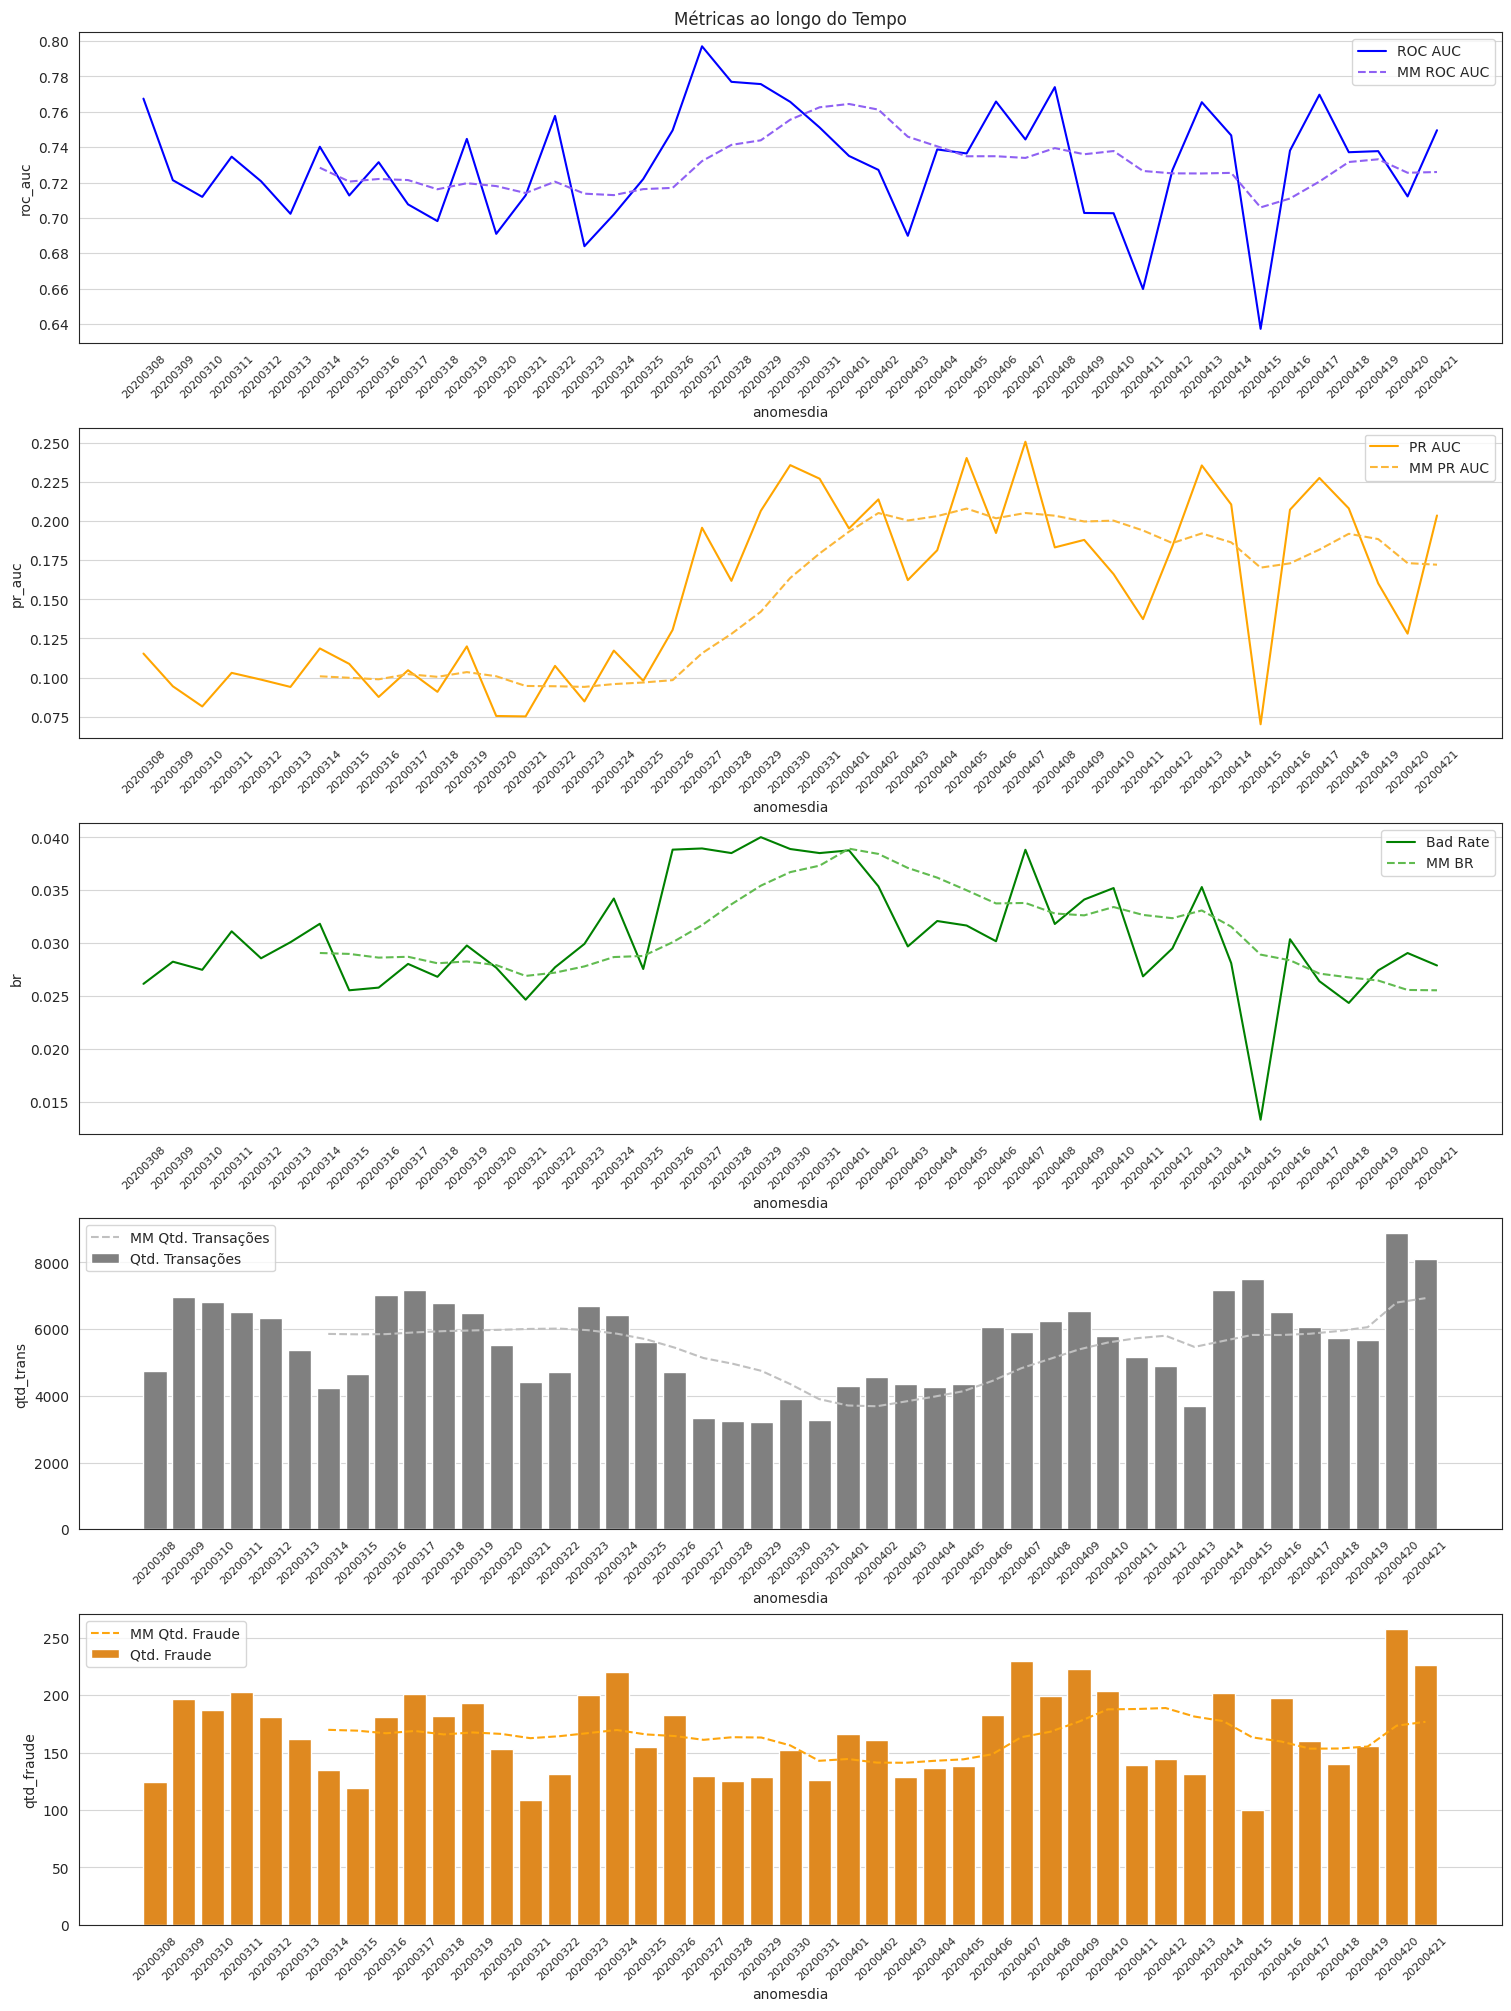

In [12]:
sns.set_style("white")

fig, axes = plt.subplots(5, 1, figsize=(15, 20),constrained_layout=True)
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='roc_auc', label='ROC AUC', ax=axes[0], color='blue')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_roc_auc', label='MM ROC AUC', ax=axes[0], linestyle="--", color='#8f61f3')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='pr_auc', label='PR AUC', ax=axes[1], color='orange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_pr_auc', label='MM PR AUC', ax=axes[1], linestyle="--", color='#fbb73a')

sns.lineplot(data=df_auc_safrada, x='anomesdia', y='br', label='Bad Rate', ax=axes[2], color='green')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_br', label='MM BR', ax=axes[2], linestyle="--", color='#61bb50')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_trans', label='Qtd. Transações', ax=axes[3], color='grey')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_trans', label='MM Qtd. Transações', ax=axes[3], linestyle="--", color='#c0c0c0')

sns.barplot(data=df_auc_safrada, x='anomesdia', y='qtd_fraude', label='Qtd. Fraude', ax=axes[4], color='darkorange')
sns.lineplot(data=df_auc_safrada, x='anomesdia', y='media_movel_qtd_fraude', label='MM Qtd. Fraude', ax=axes[4], linestyle="--", color='#fea50d')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)
    ax.grid(axis='y', linestyle="-", alpha=0.8)

axes[0].set_title('Métricas ao longo do Tempo')
plt.show()

É possível notar uma variação das métricas ao longo do tempo, e não parecem estar relacionadas a um aumento/queda da taxa de fraudes, visto que por mais que quando a badrate aumente as métricas de prauc e rocauc aumentem também, quando a badrate retorna ao seu valor usual as métricas não tem nenhuma queda.  

Então essa variação de performance pode esta relacionada a um retreino do modelo ou então modus operandi da fraude.  

Já a variação da bad rate pode ser algum efeito de sazonalidade de final de mês, onde temos a redução no volume geral de transações que não foi acompanhado por uma redução na quantidade de fraudes.  

### Estabilidade do Score

In [13]:
# Vou utilizar como referência a primeira semana do dataset

ks_day_map = {
    'Sunday' : 20200308,
    'Monday' : 20200309,
    'Tuesday' : 20200310,
    'Wednesday' : 20200311,
    'Thursday' : 20200312,
    'Friday' : 20200313,
    'Saturday' : 20200314
}

df_ks_safrado = pd.DataFrame(
    [
        [
            str(anomesdia),
            kstest(df[df['anomesdia'] == ks_day_map.get(datetime.strptime(str(anomesdia), "%Y%m%d").strftime("%A"))]['score'], 
                   df[df['anomesdia'] == anomesdia]['score'])[0]
        ]
        for anomesdia in df['anomesdia'].unique() if int(anomesdia) >= 20200315
    ],
    columns=['anomesdia', 'ks']
).sort_values(by='anomesdia')

In [52]:
df['faixa_score'] = pd.cut(df['score'], bins=range(0, 100, 5), include_lowest=True)
df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)
df_percentual = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
df_percentual.index = df_percentual.index.astype(str)

/tmp/ipykernel_325918/663662827.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df[df['anomesdia'] >= 20200315].groupby(['anomesdia', 'faixa_score']).size().unstack().fillna(0)


/tmp/ipykernel_325918/124477336.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)


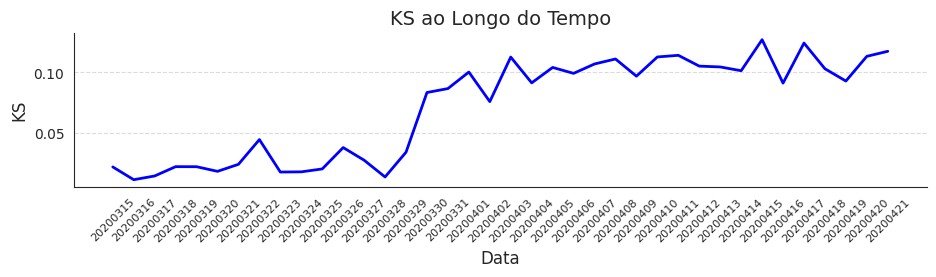

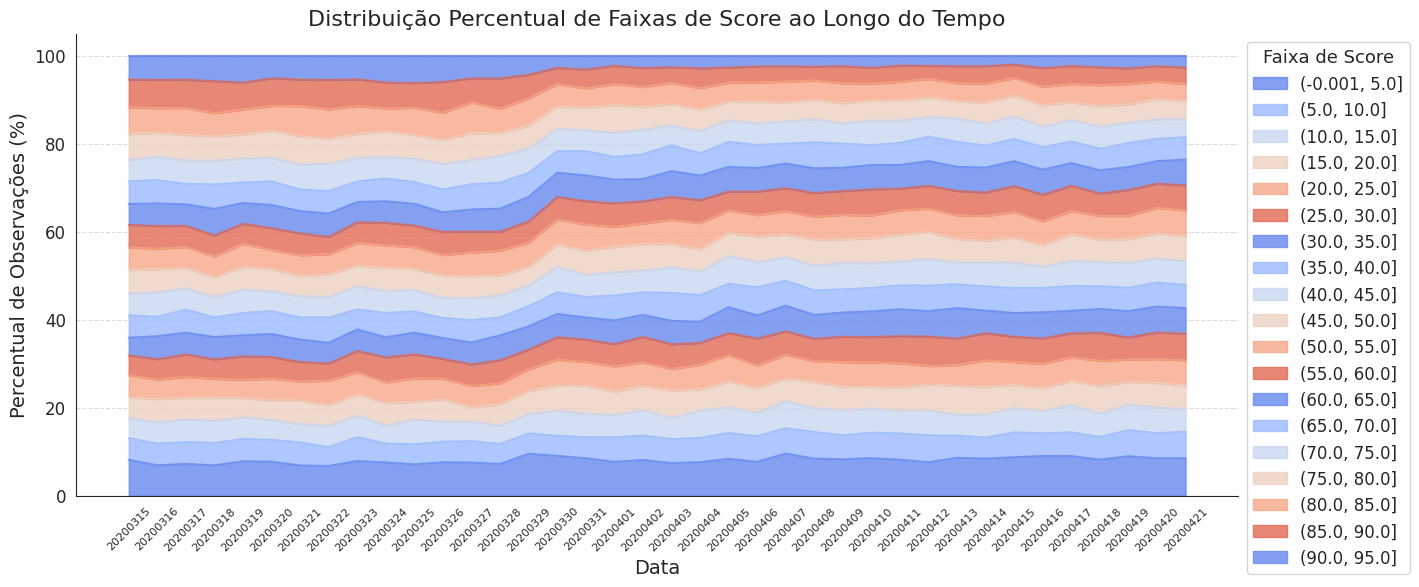

In [56]:
# KS
plt.figure(figsize=(11, 2))

sns.set_palette("coolwarm")

ax = sns.lineplot(data=df_ks_safrado, x='anomesdia', y='ks', linewidth=2, color='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=8)

ax.set_title('KS ao Longo do Tempo', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('KS', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# Distribuição Faixas de Score
ax = df_percentual.plot(kind='area', stacked=True, figsize=(15, 6), alpha=0.8)

plt.xlabel("Data", fontsize=14)
plt.ylabel("Percentual de Observações (%)", fontsize=14)
plt.title("Distribuição Percentual de Faixas de Score ao Longo do Tempo", fontsize=16)

plt.xticks(ticks=np.arange(len(df_percentual.index)), labels=df_percentual.index, rotation=45, fontsize=8)
plt.yticks(fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(title="Faixa de Score", fontsize=12, title_fontsize=13, loc='upper left', bbox_to_anchor=(1, 1))

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.show()

Avaliando o KS para entender um possível drift no score a partir de 20200330, o teste do KS nos mostra que a partir dessa data é possível descartar a hipotese nula, mostrando que provavelmente houve um retreino do modelo, pois a distribuição do score variou entre a primeira semana da tabela e a partir de dia 20200330.  

In [125]:
df_retreino = df[df['anomesdia'] >= 20200327].reset_index(drop=True)
df_ant_retreino = df[df['anomesdia'] < 20200327].reset_index(drop=True)

In [127]:
print(roc_auc_score(df_ant_retreino['fraude'], df_ant_retreino['score']))
print(roc_auc_score(df_retreino['fraude'], df_retreino['score']))

print(average_precision_score(df_ant_retreino['fraude'], df_ant_retreino['score']))
print(average_precision_score(df_retreino['fraude'], df_retreino['score']))

0.7204282573847495
0.7381962297144454
0.0977373473264336
0.18171346131675495


In [14]:
import numpy as np
from sklearn.metrics import roc_curve

def roi(X, y_true, y_pred, amount_col, max_fpr=1):
    """ Calculate ROI: (tn_amount_col * 0.05) - fn_amount_col 

    Args:
        X (pd.DataFrame): Feature matrix containing the probabilities.
        y_true (pd.Series or np.array): True labels (0 or 1).
        y_pred (pd.Series or np.array): Predicted scores.
        amount_col (str): Column name in X that represents the monetary amount.
        max_fpr (float, optional): False positive rate to cutoff the dataset.
    
    Returns:
        float: The calculated ROI value.
    """
    
    fpr, _, thresholds = roc_curve(y_true, y_pred)
    threshold = thresholds[np.argmax(fpr >= max_fpr)] if any(fpr >= max_fpr) else 1.0
    
    y_pred_cutoff = (y_pred >= threshold).astype(int)
    
    y_pred_
    # Calculate ROI
    #roi_value = (tn * 0.05) - fn
    
    return y_pred_cutoff


In [ ]:
roi(df, df['fraude'], df['score'], 'amount', 1)

0        1
1        1
2        1
3        1
4        1
        ..
99995    1
99996    1
99997    1
99998    1
99999    1
Name: score, Length: 250000, dtype: int64

In [16]:
df['score']

0        66.00
1        72.00
2        95.00
3         2.00
4        76.00
         ...  
99995    52.01
99996     6.95
99997    67.23
99998    63.77
99999    94.59
Name: score, Length: 250000, dtype: float64